<div style="float:left">
    <h1 style="width:850px">Reproducible Analysis for Traffic Resilience under flood events</h1>
    <h3 style="width:600px">CASA0012: MSc SDSV Dissertation</h3>
    <h3 style="width:600px">Author: Haisu Chen</h3>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

This notebook is the part of the Thesis supporting the reproducibility

In [1]:
import pandas as pd
import numpy as np
import os
import osmnx as ox
import scipy
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import contextily
import seaborn as sns
import matplotlib.patches as mpatches

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
dirs = 'Outputs'
if not os.path.exists(dirs):
    os.makedirs(dirs)

# Before Analysis

To fully support the reproducibility of applying assessment not only in Melbourne. The dataset imports are ahead of the analysis.

If wish to apply this on other city, please follow the workflow and replace the datasets and the variables below.

**To Note**: In the final stage of visualisation, adaptive edits are required if applies another city.

## Data Import

### Define the Study Area

In [3]:
StudyArea = 'City of Melbourne'
CRS = 'epsg:32755'

### Import the shapefiles of state

In [4]:
import requests, zipfile, io
zip_file_url = 'https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/SA4_2021_AUST_SHP_GDA2020.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("Resources")

In [5]:
state = gpd.read_file('Resources/SA4_2021_AUST_GDA2020.shp')

### Define the path for flood maps and features

In [6]:
## Define the path for Flood inundation map and feature for severely inundated area on road
FloodMapPath = 'Resources/FloodMap.tif'
Class3FeaturePath = 'Resources/Class3_poly.shp'

### Import the census data and boundaries of Mesh Blocks

In [7]:
## Import census data and extracted geographical boundaries of Mesh Blocks
census = pd.ExcelFile('https://www.abs.gov.au/census/guide-census-data/mesh-block-counts/2021/Mesh%20Block%20Counts%2C%202021.xlsx')

VicCen1 = census.parse('Table 2',header=1, skiprows=5, skipfooter=4)
VicCen2 = census.parse('Table 2.1',header=1, skiprows=5, skipfooter=4)

VicCen = pd.concat([VicCen1,VicCen2])

VicCen['MB_CODE_2021'] = VicCen['MB_CODE_2021'].astype(str)

In [8]:
## The Mesh Blocks within the city boundary are achivevd from QGIS due to boundary issues
gdf_MB = gpd.read_file('Resources/Melbourne_MB.shp')
gdf_MB = gdf_MB.rename(columns={"MB_CODE21": "MB_CODE_2021"})

gdf_MB_census = gdf_MB.merge(VicCen,how='left',on='MB_CODE_2021')
columns = ['MB_CODE_2021','MB_CAT21','SA2_NAME21','AREASQKM21','Dwelling','Person','geometry']
gdf_MB_census = gdf_MB_census[columns].copy()

<AxesSubplot:>

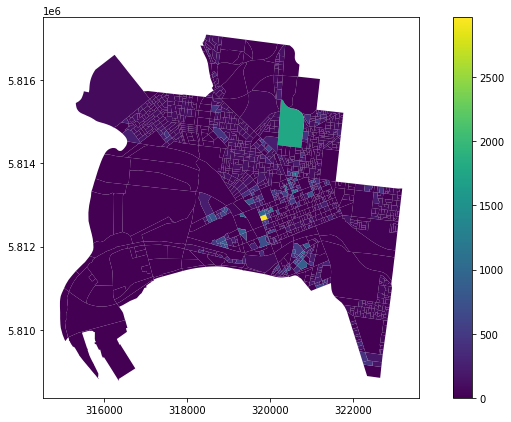

In [9]:
fig, ax = plt.subplots(figsize=(12,7))
gdf_MB_census.plot(column = 'Person',legend=True, ax=ax)

In [10]:
gdf_MB_census['ref']=999

In [11]:
Boundary = gdf_MB_census.dissolve(by='ref')

## Color Schemes

Suitable color ramps should be carefully selected and defined for indicating progressive variation of values before visualisation

In [12]:
import matplotlib.colors
def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

In [13]:
colormap = plt.cm.get_cmap('plasma', 30)
color = categorical_cmap(30, 1, cmap=colormap)

In [14]:
colormap2 = plt.cm.get_cmap('viridis_r', 30)
color2 = categorical_cmap(30, 1, cmap=colormap2)

In [15]:
colormap3 = plt.cm.get_cmap('magma_r', 30)
color3 = categorical_cmap(30, 1, cmap=colormap3)

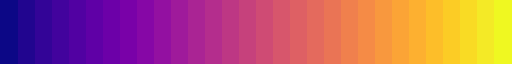

In [16]:
color

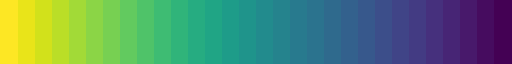

In [17]:
color2

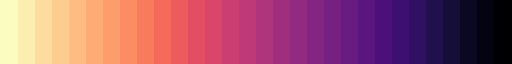

In [18]:
color3

In [19]:
color.colors[0]

array([0.050383, 0.029803, 0.527975])

In [20]:
sns.set_theme(style="ticks")

# Reproducible Analysis Workflow

Package of OSMNX is applied to obtain the roadway network for the study area

## Prepartion of Graph

In [21]:
Graph = ox.graph_from_place(StudyArea, network_type='drive')
print(type(Graph))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [22]:
G = ox.projection.project_graph(Graph, to_crs=CRS)

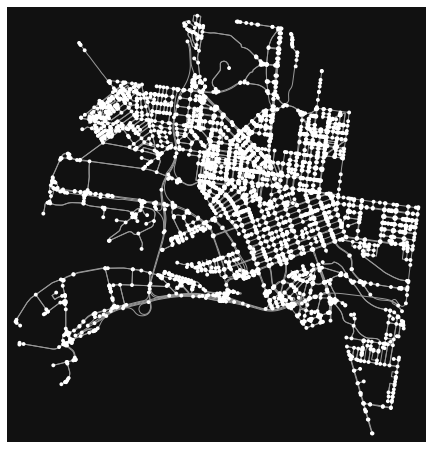

In [23]:
fig, ax = ox.plot_graph(Graph)

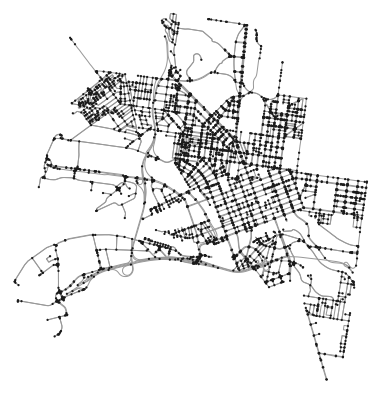

In [24]:
fig, ax = plt.subplots(figsize=(12,7))
fig, ax = ox.plot_graph(Graph, 
                        node_color='k',
                        node_size = 5,
                        ax=ax)

In [25]:
# Examine the basic status of the Graph
stats = ox.basic_stats(Graph)
stats

{'n': 4102,
 'm': 8088,
 'k_avg': 3.9434422233057047,
 'edge_length_total': 593902.0840000014,
 'edge_length_avg': 73.43003016815052,
 'streets_per_node_avg': 3.1950268161872257,
 'streets_per_node_counts': {0: 0,
  1: 208,
  2: 51,
  3: 2602,
  4: 1217,
  5: 22,
  6: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.050706972208678695,
  2: 0.012432959531935642,
  3: 0.6343247196489518,
  4: 0.29668454412481715,
  5: 0.005363237445148708,
  6: 0.00048756704046806434},
 'intersection_count': 3894,
 'street_length_total': 468868.0130000021,
 'street_segment_count': 6465,
 'street_length_avg': 72.52405460170179,
 'circuity_avg': 1.0324102764032996,
 'self_loop_proportion': 0.0006187161639597834}

In [26]:
# Convert the Graph into GeoDataFrames - Nodes and Edges
nodes, edges = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

In [27]:
nodes['nodeName'] = nodes.index
nodes

y              x  street_count         lon        lat  \
osmid                                                                          
21578145    5.811521e+06  318505.234057             3  144.937782 -37.825690   
683094366   5.810938e+06  316796.195356             3  144.918227 -37.830597   
26034526    5.812807e+06  319967.726422             4  144.954709 -37.814398   
259616706   5.812812e+06  319980.005354             4  144.954850 -37.814358   
6207096572  5.812848e+06  319952.588986             3  144.954548 -37.814023   
...                  ...            ...           ...         ...        ...   
9950383645  5.811060e+06  321294.405574             3  144.969341 -37.830398   
9950383651  5.811056e+06  321293.165369             3  144.969326 -37.830427   
9950383689  5.811140e+06  321268.258396             3  144.969064 -37.829673   
9950383653  5.811066e+06  321327.505133             3  144.969719 -37.830350   
9950383694  5.811184e+06  321258.402623             3  144.968963 -37.829272   

           highway  ref                        geometry    nodeName  
osmid                                                                
21578145       NaN  NaN  POINT (318505.234 5811521.221)    21578145  
683094366      NaN  NaN  POINT (316796.195 5810938.462)   683094366  
26034526       NaN  NaN  POINT (319967.726 5812806.986)    26034526  
259616706      NaN  NaN  POINT (319980.005 5812811.752)   259616706  
6207096572     NaN  NaN  POINT (319952.589 5812848.298)  6207096572  
...            ...  ...                             ...         ...  
9950383645     NaN  NaN  POINT (321294.406 5811059.663)  9950383645  
9950383651     NaN  NaN  POINT (321293.165 5811056.361)  9950383651  
9950383689     NaN  NaN  POINT (321268.258 5811139.594)  9950383689  
9950383653     NaN  NaN  POINT (321327.505 5811065.745)  9950383653  
9950383694     NaN  NaN  POINT (321258.403 5811183.832)  9950383694  

[4102 rows x 9 columns]

In [28]:
df_edge = edges.copy().reset_index()

df_edge['item'] = list(zip(df_edge.u, df_edge.v, df_edge.key))

In [29]:
list(G.nodes(data = True))[0]

(21578145,
 {'y': 5811521.221290696,
  'x': 318505.23405692476,
  'street_count': 3,
  'lon': 144.9377819,
  'lat': -37.8256899})

In [30]:
list(G.edges(data = True))[0]

(21578145,
 683094366,
 {'osmid': [484854832, 28119418, 1083073387, 775968519],
  'oneway': True,
  'lanes': ['3', '4'],
  'ref': 'M1',
  'name': 'West Gate Freeway',
  'highway': 'motorway',
  'maxspeed': '80',
  'length': 1827.578,
  'geometry': <shapely.geometry.linestring.LineString at 0x7f3db729c9a0>})

In [31]:
x = nodes.centroid.x
y = nodes.centroid.y

coor = {key: (x[key], y[key]) for key in x.index}

nx.set_node_attributes(G,coor,'coor')

In [32]:
pos = nx.get_node_attributes(G, 'coor')

In [33]:
nodeRef=dict(G.nodes(data="nodeID", default=1))
nodeName = {k: k for k, v in nodeRef.items()}

In [34]:
nx.set_node_attributes(G,nodeName,'nodeName')

In [35]:
degree = dict(nx.degree(G))
nx.set_node_attributes(G, degree, 'degree')

In [36]:
nx.info(G)

'MultiDiGraph with 4102 nodes and 8088 edges'

Buffer the edges, i.e. polyline, to represent the street, i.e. polygon.

In [37]:
edges_buff = df_edge.copy()
edges_buff['geometry'] = edges_buff.buffer(3)
edges_buff = edges_buff[~(edges_buff['geometry'].is_empty | edges_buff['geometry'].isna())]

In [38]:
edges_buff.head(2)

u           v  key                                         osmid  \
0   21578145   683094366    0  [484854832, 28119418, 1083073387, 775968519]   
1  683094366  9360244981    0                        [995761509, 289975598]   

   oneway   lanes ref               name   highway maxspeed    length  \
0    True  [3, 4]  M1  West Gate Freeway  motorway       80  1827.578   
1    True  [5, 4]  M1  West Gate Freeway  motorway       80   450.958   

                                            geometry access bridge junction  \
0  POLYGON ((318452.139 5811512.046, 318369.220 5...    NaN    NaN      NaN   
1  POLYGON ((316625.255 5810818.191, 316625.252 5...    NaN    NaN      NaN   

  tunnel width service                        item  
0    NaN   NaN     NaN    (21578145, 683094366, 0)  
1    NaN   NaN     NaN  (683094366, 9360244981, 0)

In [39]:
# Conduct zonal statistics on Flood depths map by the feature of buffered edges.
# For each polygon of buffered edge, the mean value of depth within the polygon is supposed to be summarised.

edges_buff = edges_buff.join(
    pd.DataFrame(
        zonal_stats(
            vectors=edges_buff['geometry'], 
            raster= FloodMapPath, 
            stats=['mean']
        )
    ),
    how='left'
)

In [40]:
# Fill the NoData of mean depth in the buffered edges with 0
meanDepth = edges_buff['mean'].fillna(0)

In [41]:
meanDepth

0       0.040370
1       0.024714
2       0.000000
3       0.000000
4       0.000000
          ...   
8083    0.328909
8084    0.000000
8085    0.045573
8086    0.109339
8087    0.000000
Name: mean, Length: 8088, dtype: float64

In [42]:
edges_buff['mean'].describe()

count    3.095000e+03
mean     1.711130e-01
std      1.782833e-01
min      3.352761e-07
25%      5.283372e-02
50%      1.169554e-01
75%      2.248501e-01
max      1.511455e+00
Name: mean, dtype: float64

In [43]:
df2 = df_edge.copy()

In [44]:
# Examine the column name of road type of the Graph obtained from OSMNX
list1 = df2[df2['maxspeed'].isnull()]['highway']
output = []
for x in list1:
    if x not in output:
        output.append(x)
print(output)

['trunk_link', 'tertiary_link', 'residential', 'unclassified', 'tertiary', ['motorway_link', 'primary_link'], 'primary', 'motorway_link', 'trunk', 'primary_link', 'secondary', 'living_street', 'secondary_link', ['trunk', 'motorway_link'], 'disused', ['tertiary_link', 'unclassified']]


In [45]:
# Examine the records of maxspeed recorded in the Graph
list2 = df2['maxspeed'].tolist()

output = []
for x in list2:
    if x not in output:
        output.append(x)
print(output)

['80', '40', nan, '20', '50', '60', '70', ['60', '70'], ['40', '50'], ['60', '50'], ['60', '80'], '10', '30', ['60', '40'], ['40;60', '40; 60', '60;40;60'], '40; 60', ['40;60', '40; 60'], ['10', '50'], ['100', '80']]


Tidy up the column of max-speed.

In [46]:
# First attempt to convert the data type from string to float since the original data type of 'maxspeed' recorded in the Graph is string
new_maxspeed = []
for i in df2.index:
    temporowspd = df2.iloc[i]['maxspeed']
    temporoadtype = df2.iloc[i]['highway']
    try:
        tempo_value = float(temporowspd)
    except:
        try:
            tempo_value = float(df2[df2['highway']==temporoadtype]['maxspeed'].value_counts().idxmax())
            # Record the most occurred maxspeed for this road type in the List
        except:
            tempo_value = np.nan
            new_maxspeed.append(tempo_value)
        else:
            new_maxspeed.append(tempo_value)
    else:
        new_maxspeed.append(tempo_value)
            

In [47]:
len(new_maxspeed)

8088

In [48]:
# Second attempt to convert the data type of 'maxspeed' with cleanning
new_maxspeed2 = []
for i in df2.index:
    temporow = df2.iloc[i]['maxspeed']
    if type(temporow) == str:
        #temporow = temporow.replace('; ',';')
        #tempo = temporow.split(';')
        #tempo_value = np.mean([int(x) for x in tempo])
        tempo_value = new_maxspeed[i]
        #tempo_value = int(df2.iloc[i]['maxspeed'])
        #print(i,tempo_value)
    if isinstance(temporow, list):
        catresult = []
        
        for item in temporow:

            item = item.replace('; ',';')
            tempo2 = item.split(';')
            result = [float(x) for x in tempo2]
            catresult.append(result)
        fin=[]
        for item2 in catresult:
            fin.extend(item2)
        tempo_value = np.mean(fin)
   # print(i,tempo_value)
    new_maxspeed2.append(tempo_value)

In [49]:
df2['maxspeed_new'] = new_maxspeed2

In [50]:
df2['maxspeed_new'].describe()

count    8088.000000
mean       50.257348
std        10.057743
min        10.000000
25%        40.000000
50%        50.000000
75%        60.000000
max        90.000000
Name: maxspeed_new, dtype: float64

In [51]:
df2['maxspeed_new']

0       80.0
1       80.0
2       40.0
3       40.0
4       40.0
        ... 
8083    60.0
8084    60.0
8085    60.0
8086    50.0
8087    50.0
Name: maxspeed_new, Length: 8088, dtype: float64

In [52]:
df2['length'].describe()

count    8088.000000
mean       73.430030
std       107.544874
min         0.378000
25%        13.628500
50%        42.074000
75%        95.301000
max      1996.900000
Name: length, dtype: float64

## Calculation of the travel time

In [53]:
maxspeed_ms = df2.maxspeed_new * 0.277777778

df2['travel_time'] = df2.length / maxspeed_ms

df2['mean_depth'] = meanDepth * 1000

df2['mean_depth'] = df2['mean_depth'].fillna(0)

In [54]:
# Label the feature of bridge that has mean depth over 100
# Given the limitation of evaluating the flooded bridge, the attribute of depth for inundated bridge features is mannuly defined.

for index in df2.index:
  if df2.loc[index,'bridge'] == 'yes' and df2.loc[index,'mean_depth'] >100:
    df2.loc[index,'mean_depth'] = 50

In [55]:
len(df2)

8088

In [56]:
df2[df2['mean_depth']<0.3]['mean_depth'].count()

4995

In [57]:
df2.columns

Index(['u', 'v', 'key', 'osmid', 'oneway', 'lanes', 'ref', 'name', 'highway',
       'maxspeed', 'length', 'geometry', 'access', 'bridge', 'junction',
       'tunnel', 'width', 'service', 'item', 'maxspeed_new', 'travel_time',
       'mean_depth'],
      dtype='object')

Calculate the delayed travel time by depth-speed function

In [58]:
df2['delaymaxspeed'] = 0.0009 * (df2.mean_depth) ** 2 - 0.5529 * (df2.mean_depth) + 86.9448

df2['limitspeed']=df2.loc[:,['delaymaxspeed','maxspeed_new']].T.min()

delaymaxspeed_ms = df2.limitspeed * 0.277777778

df2['delay_traveltime'] = df2.length / delaymaxspeed_ms

# delay traveltime ratio obtained here is for single edge
df2['delay_timeratio'] = (df2.delay_traveltime - df2.travel_time)/df2.travel_time

In [59]:
df2['direction'] = list(zip(df2.u, df2.v))

In [60]:
df2.head(2)

u           v  key                                         osmid  \
0   21578145   683094366    0  [484854832, 28119418, 1083073387, 775968519]   
1  683094366  9360244981    0                        [995761509, 289975598]   

   oneway   lanes ref               name   highway maxspeed  ...  service  \
0    True  [3, 4]  M1  West Gate Freeway  motorway       80  ...      NaN   
1    True  [5, 4]  M1  West Gate Freeway  motorway       80  ...      NaN   

                         item maxspeed_new travel_time mean_depth  \
0    (21578145, 683094366, 0)         80.0   82.398676  40.369830   
1  (683094366, 9360244981, 0)         80.0   20.316662  24.713892   

  delaymaxspeed limitspeed delay_traveltime delay_timeratio  \
0     66.091072  66.091072        99.739555        0.210451   
1     73.830188  73.830188        22.014477        0.083568   

                 direction  
0    (21578145, 683094366)  
1  (683094366, 9360244981)  

[2 rows x 27 columns]

In [61]:
df_edge.head(2)

u           v  key                                         osmid  \
0   21578145   683094366    0  [484854832, 28119418, 1083073387, 775968519]   
1  683094366  9360244981    0                        [995761509, 289975598]   

   oneway   lanes ref               name   highway maxspeed    length  \
0    True  [3, 4]  M1  West Gate Freeway  motorway       80  1827.578   
1    True  [5, 4]  M1  West Gate Freeway  motorway       80   450.958   

                                            geometry access bridge junction  \
0  LINESTRING (318505.234 5811521.221, 318451.759...    NaN    NaN      NaN   
1  LINESTRING (316796.195 5810938.462, 316623.564...    NaN    NaN      NaN   

  tunnel width service                        item  
0    NaN   NaN     NaN    (21578145, 683094366, 0)  
1    NaN   NaN     NaN  (683094366, 9360244981, 0)

Create the dictionaries using item as key, travel time / single edge's delayed ratio / mean depth / direction

In [62]:
dic_delay_traveltime = dict(zip(df2.item, df2.delay_traveltime))

dic_delay_timeratio = dict(zip(df2.item, df2.delay_timeratio))

dic_traveltime = dict(zip(df2.item, df2.travel_time))

dic_flooddepth = dict(zip(df2.item, df2.mean_depth))

dic_dir = dict(zip(df2.item, df2.direction))

In [63]:
len(dic_delay_traveltime)

8088

In [64]:
nx.info(G)

'MultiDiGraph with 4102 nodes and 8088 edges'

Add the attributes that prepared before into the edges of the Graph

In [65]:
nx.set_edge_attributes(G, dic_delay_traveltime,'delay_traveltime')

nx.set_edge_attributes(G, dic_traveltime,'traveltime')

nx.set_edge_attributes(G, dic_delay_timeratio,'delay_timeratio')

nx.set_edge_attributes(G, dic_flooddepth, 'flooddepth')

nx.set_edge_attributes(G, dic_dir,'direction')


In [66]:
list(G.edges(data = True))[10]

(2020813831,
 2020813871,
 {'osmid': 296383691,
  'oneway': True,
  'name': 'Queen Street',
  'highway': 'tertiary',
  'maxspeed': '40',
  'length': 110.82499999999999,
  'geometry': <shapely.geometry.linestring.LineString at 0x7f3daa5698b0>,
  'delay_traveltime': 9.96073324486244,
  'traveltime': 9.96073324486244,
  'delay_timeratio': 0.0,
  'flooddepth': 0.0,
  'direction': (2020813831, 2020813871)})

## Read the feature of class3 flood inundation 

In [67]:
gdf_flood = gpd.read_file(Class3FeaturePath)
gdf_flood.crs

<Derived Projected CRS: EPSG:32755>
Name: WGS 84 / UTM zone 55S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 144°E and 150°E, southern hemisphere between 80°S and equator, onshore and offshore. Australia. Papua New Guinea.
- bounds: (144.0, -80.0, 150.0, 0.0)
Coordinate Operation:
- name: UTM zone 55S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

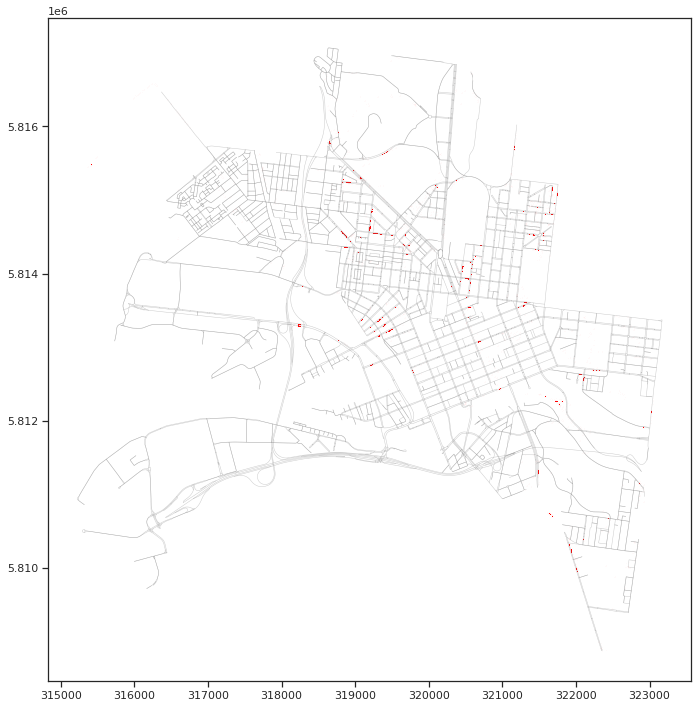

In [68]:
fig, ax = plt.subplots(figsize=(15,10))
gdf_flood.plot(ax=ax,facecolor='red')
edges.plot(ax=ax, color='gray', linewidth=0.5,alpha=0.4)
plt.tight_layout()

## Removal of edges and nodes

In [69]:
gdf_flood

Class                                           geometry
0         3  POLYGON ((319477.257 5816960.998, 319485.838 5...
1         3  POLYGON ((319554.488 5816952.416, 319563.070 5...
2         3  POLYGON ((319571.651 5816952.416, 319580.232 5...
3         3  POLYGON ((319588.814 5816952.416, 319597.395 5...
4         3  POLYGON ((319477.257 5816900.929, 319485.838 5...
...     ...                                                ...
1318      3  POLYGON ((322334.832 5808937.477, 322343.413 5...
1319      3  POLYGON ((322326.250 5808928.895, 322334.832 5...
1320      3  POLYGON ((322360.575 5808885.989, 322412.063 5...
1321      3  POLYGON ((322412.063 5808877.408, 322420.645 5...
1322      3  POLYGON ((322437.807 5808877.408, 322463.551 5...

[1323 rows x 2 columns]

Query the nodes that are in disrupted by using *intersections*.

In [70]:
nodes

y              x  street_count         lon        lat  \
osmid                                                                          
21578145    5.811521e+06  318505.234057             3  144.937782 -37.825690   
683094366   5.810938e+06  316796.195356             3  144.918227 -37.830597   
26034526    5.812807e+06  319967.726422             4  144.954709 -37.814398   
259616706   5.812812e+06  319980.005354             4  144.954850 -37.814358   
6207096572  5.812848e+06  319952.588986             3  144.954548 -37.814023   
...                  ...            ...           ...         ...        ...   
9950383645  5.811060e+06  321294.405574             3  144.969341 -37.830398   
9950383651  5.811056e+06  321293.165369             3  144.969326 -37.830427   
9950383689  5.811140e+06  321268.258396             3  144.969064 -37.829673   
9950383653  5.811066e+06  321327.505133             3  144.969719 -37.830350   
9950383694  5.811184e+06  321258.402623             3  144.968963 -37.829272   

           highway  ref                        geometry    nodeName  
osmid                                                                
21578145       NaN  NaN  POINT (318505.234 5811521.221)    21578145  
683094366      NaN  NaN  POINT (316796.195 5810938.462)   683094366  
26034526       NaN  NaN  POINT (319967.726 5812806.986)    26034526  
259616706      NaN  NaN  POINT (319980.005 5812811.752)   259616706  
6207096572     NaN  NaN  POINT (319952.589 5812848.298)  6207096572  
...            ...  ...                             ...         ...  
9950383645     NaN  NaN  POINT (321294.406 5811059.663)  9950383645  
9950383651     NaN  NaN  POINT (321293.165 5811056.361)  9950383651  
9950383689     NaN  NaN  POINT (321268.258 5811139.594)  9950383689  
9950383653     NaN  NaN  POINT (321327.505 5811065.745)  9950383653  
9950383694     NaN  NaN  POINT (321258.403 5811183.832)  9950383694  

[4102 rows x 9 columns]

In [71]:
# Buffer the node to represent the junctions
nodes_buff = nodes.copy()
nodes_buff['geometry'] = nodes.buffer(3)

In [72]:
intersection_node = gpd.sjoin(
    nodes_buff,
    gdf_flood,
    how='inner',
    predicate='intersects',
)

In [73]:
# Query the edge that has mean flood depth over 300, which will be labelled as disrupted road
df_failure = df2[df2['mean_depth']>=300].copy()

In [74]:
df_failure.columns

Index(['u', 'v', 'key', 'osmid', 'oneway', 'lanes', 'ref', 'name', 'highway',
       'maxspeed', 'length', 'geometry', 'access', 'bridge', 'junction',
       'tunnel', 'width', 'service', 'item', 'maxspeed_new', 'travel_time',
       'mean_depth', 'delaymaxspeed', 'limitspeed', 'delay_traveltime',
       'delay_timeratio', 'direction'],
      dtype='object')

In [75]:
df_failure['item']

83        (26034672, 1985557912, 0)
89         (26034673, 595594352, 0)
92        (595594352, 595594353, 0)
119       (26121234, 6731366474, 0)
122     (6731366474, 6731366481, 0)
                   ...             
8004    (8973667567, 9515157446, 0)
8058    (9308089035, 9308089037, 0)
8065    (9308089038, 9308089035, 0)
8082     (9950383645, 444352328, 0)
8083    (9950383651, 9950383645, 0)
Name: item, Length: 486, dtype: object

In [76]:
edges_toremove = df_failure['item'].copy()
print(len(edges_toremove))

486


In [77]:
nodes_toremove = intersection_node['nodeName'].tolist()
print(len(nodes_toremove))

244


Duplicate the Grpah for preparing the removal of nodes and edges

In [78]:
G2 = G.copy()

In [79]:
len(G2)

4102

In [80]:
list(G2.edges(data = True))[0]

(21578145,
 683094366,
 {'osmid': [484854832, 28119418, 1083073387, 775968519],
  'oneway': True,
  'lanes': ['3', '4'],
  'ref': 'M1',
  'name': 'West Gate Freeway',
  'highway': 'motorway',
  'maxspeed': '80',
  'length': 1827.578,
  'geometry': <shapely.geometry.linestring.LineString at 0x7f3db729c9a0>,
  'delay_traveltime': 99.73955500505527,
  'traveltime': 82.39867591368365,
  'delay_timeratio': 0.21045094352653163,
  'flooddepth': 40.369830480436,
  'direction': (21578145, 683094366)})

Removal of nodes from flood cover; removal of edges from query road segements that have mean depth over 0.3m.

In [81]:
# Remove the disrupted edges and nodes from the Graph
G2.remove_edges_from(edges_toremove)
G2.remove_nodes_from(nodes_toremove)

In [82]:
print(nx.info(G))

MultiDiGraph with 4102 nodes and 8088 edges


In [83]:
print(nx.info(G2))

MultiDiGraph with 3859 nodes and 7179 edges


Export the nodes and edges for G and G2 in GeoDataFrame

In [84]:
G_nodes, G_edges = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

nodes_2, edges_2= ox.utils_graph.graph_to_gdfs(G2, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)


In [85]:
edges_2.columns

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'length', 'geometry', 'delay_traveltime', 'traveltime',
       'delay_timeratio', 'flooddepth', 'direction', 'access', 'bridge',
       'junction', 'tunnel', 'width', 'service'],
      dtype='object')

## Study area plotting

Examine once again of the geographical data imported for preparing the visualisations

In [86]:
state.crs

<Geographic 2D CRS: EPSG:7844>
Name: GDA2020
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia including Lord Howe Island, Macquarie Island, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore.
- bounds: (93.41, -60.55, 173.34, -8.47)
Datum: Geocentric Datum of Australia 2020
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [87]:
# Convert the crs
Boundary2 = Boundary.to_crs('epsg:7844')

In [88]:
melbourne = state[state['SA4_NAME21']=='Melbourne - Inner']
victoria = state[state['STE_NAME21']=='Victoria']


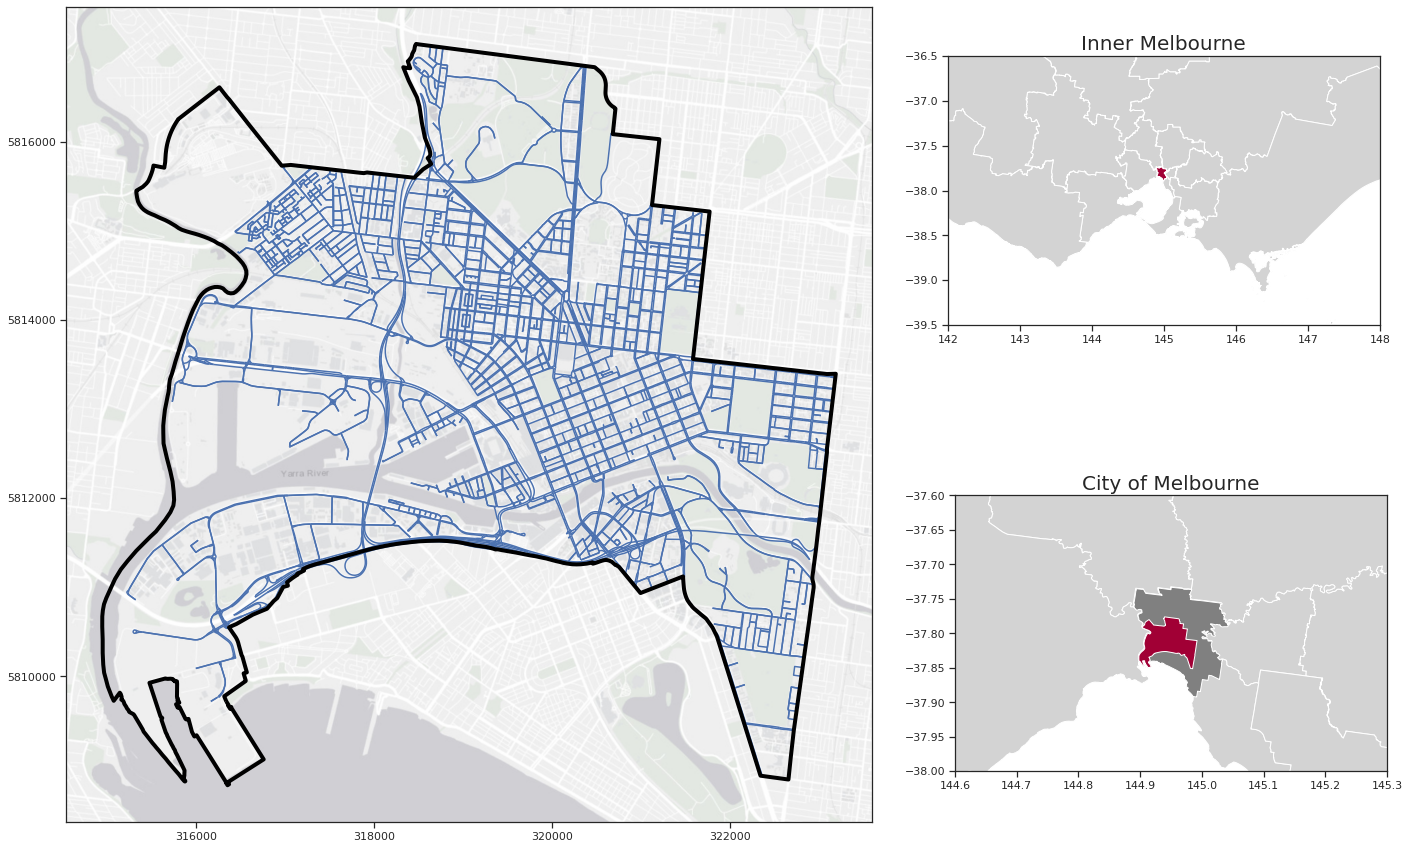

In [89]:
fig,ax=plt.subplots(figsize=(20,15))
edges.plot(ax=ax)
Boundary.plot(color='none',edgecolor='black',linewidth=4,alpha=1,ax=ax,zorder=25)
plt.ticklabel_format(style='plain')
contextily.add_basemap(ax,
            crs=edges.crs, 
            source=contextily.providers.Esri.WorldGrayCanvas,
            attribution = False
            )

ax2 = fig.add_axes([0.845, 0.56, 0.3, 0.3])
melbourne.plot(color='#A10035',ax=ax2,zorder=5)
state.plot(color='lightgrey',ax=ax2,zorder=1)
victoria.plot(color='lightgrey',ax=ax2,zorder=2)
ax2.set(xlim=(142, 148), ylim=(-39.5, -36.5))
ax2.set_xlim(142, 148)
ax2.set_ylim(-39.5, -36.5)
#ax2.axis('off')
ax2.set_title('Inner Melbourne', fontdict={'fontsize':'20', 'fontweight':'5'})


ax3 = fig.add_axes([0.85, 0.15, 0.3, 0.3])
Boundary2.plot(color='#A10035',ax=ax3,edgecolor='white',linewidth=1,zorder=5)
melbourne.plot(color='grey',ax=ax3,zorder=2)

state.plot(color='lightgrey',ax=ax3,zorder=1)
ax3.set(xlim=(144.6, 145.3), ylim=(-37.6, -38))
ax3.set_xlim(144.6, 145.3)
ax3.set_ylim(-38, -37.6)
ax3.set_title('City of Melbourne', fontdict={'fontsize':'20', 'fontweight':'5'})
#ax3.axis('off')
plt.ticklabel_format(style='plain')
plt.savefig('Outputs/StudyArea.png',dpi=400,bbox_inches='tight')

## Visualisation of network connectivty and functionality

<ipython-input-90-62f8298b3cf8>:10: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  l1 = plt.legend([fig],


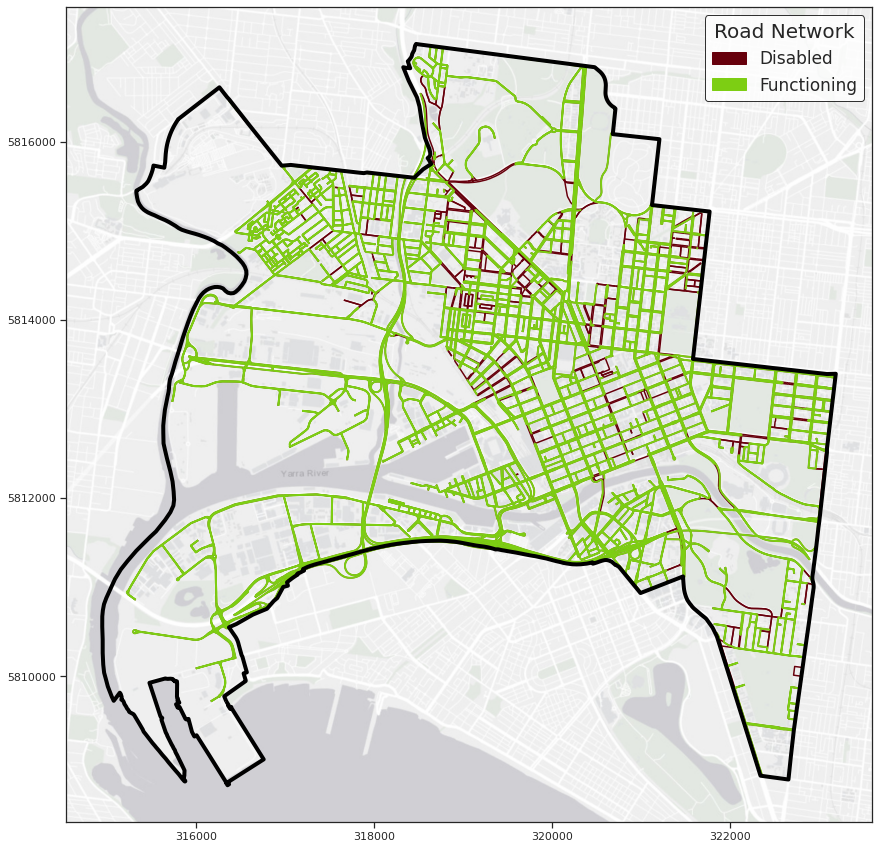

In [90]:
fig, ax = plt.subplots(figsize=(20,15))
color_1 = '#67000c'
color_2 = '#7DCE13'
cl=[mpatches.Patch(color=color_1,label='Disabled'),mpatches.Patch(color=color_2,label='Functioning')]
G_edges.plot(ax=ax,color=color_1,legend=True, linewidth=1.5,alpha=1,zorder=2)
edges_2.plot(ax=ax,color=color_2,legend=True, linewidth=2,alpha=1,zorder=5)
#Boundary.plot(ax=ax,facecolor='grey',alpha=0.3,zorder=1)
Boundary.plot(color='none',edgecolor='black',linewidth=4,alpha=1,ax=ax,zorder=25)

l1 = plt.legend([fig], 
                handles=cl,
                loc='upper right',
                title_fontsize = 20,
                fontsize = 17,
                title = 'Road Network',
                frameon=True)
l1.get_frame().set_edgecolor('black')
l1.get_frame().set_linewidth(1)

contextily.add_basemap(ax,
            crs=G_edges.crs, 
            source=contextily.providers.Esri.WorldGrayCanvas,
            attribution = False
            )
plt.ticklabel_format(style='plain')

#plt.savefig('Networks.png',bbox_inches='tight')


In [91]:
G_edges.columns

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'length', 'geometry', 'delay_traveltime', 'traveltime',
       'delay_timeratio', 'flooddepth', 'direction', 'access', 'bridge',
       'junction', 'tunnel', 'width', 'service'],
      dtype='object')

<ipython-input-92-63aedd65bb73>:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  l0 = plt.legend([fig],
<ipython-input-92-63aedd65bb73>:33: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  l2 = plt.legend([fig],


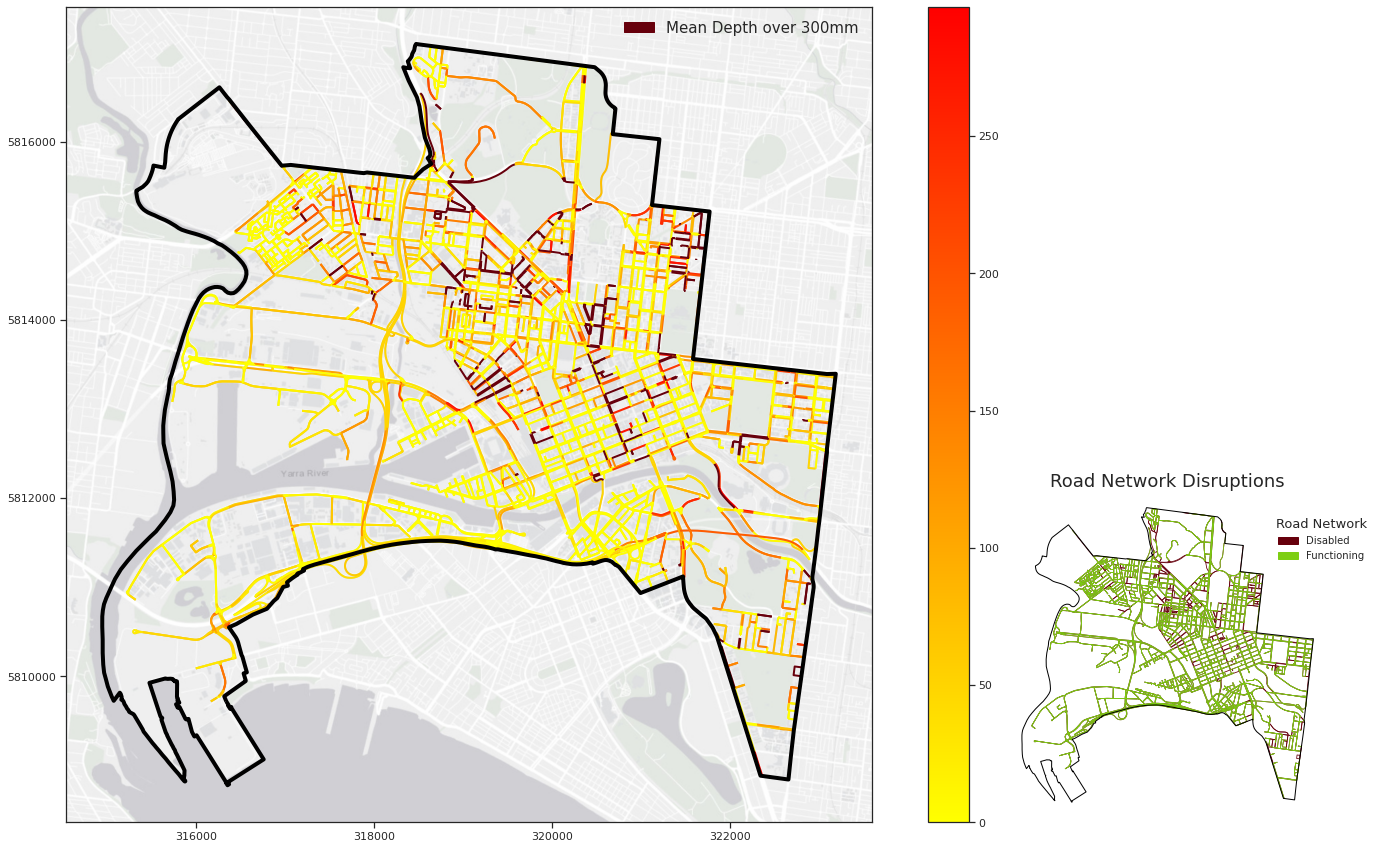

In [92]:
fig, ax = plt.subplots(figsize=(20,15))
color_1='#67000c'

G_edges[G_edges['flooddepth']>=300].plot(ax=ax,color=color_1,legend=True, linewidth=2,alpha=1,zorder=3)
edges_2.plot(ax=ax,column='flooddepth',cmap='autumn_r',legend=True, linewidth=2,alpha=1,zorder=2)
edges_2.plot(ax=ax,color='lightgrey',legend=True,linewidth=2,alpha=1,zorder=1)
#Boundary.plot(ax=ax,facecolor='grey',alpha=0.3,zorder=1)
Boundary.plot(color='none',edgecolor='black',linewidth=4,alpha=1,ax=ax,zorder=25)
plt.ticklabel_format(style='plain')
cl0=[mpatches.Patch(color='#67000c',label='Mean Depth over 300mm')]
l0 = plt.legend([fig], 
                handles=cl0,
                loc='upper right',
                title_fontsize = 18,
                fontsize = 15,
                title = '',
                frameon=False)
l0.get_frame().set_edgecolor('black')
l0.get_frame().set_linewidth(1)


ax2 = fig.add_axes([0.8, 0.13, 0.3, 0.3])
color_2 = '#67000c'
color_3 = '#7DCE13'
G_edges.plot(ax=ax2,color=color_2,legend=True, linewidth=0.8,alpha=1,zorder=2)
edges_2.plot(ax=ax2,color=color_3,legend=True, linewidth=0.8,alpha=1,zorder=5)
#Boundary.plot(ax=ax,facecolor='grey',alpha=0.3,zorder=1)
Boundary.plot(color='none',edgecolor='black',linewidth=1,alpha=1,ax=ax2,zorder=25)
ax2.axis('off')

cl=[mpatches.Patch(color=color_2,label='Disabled'),mpatches.Patch(color=color_3,label='Functioning')]

l2 = plt.legend([fig], 
                handles=cl,
                bbox_to_anchor=(1.15, 0.95),
                loc='upper right',
                title_fontsize = 13,
                fontsize = 10,
                title = 'Road Network',
                frameon=False)
l2.get_frame().set_edgecolor('black')
l2.get_frame().set_linewidth(1)
ax2.set_title('Road Network Disruptions', fontdict={'fontsize':'18', 'fontweight':'5'})

contextily.add_basemap(ax,
            crs=G_edges.crs, 
            source=contextily.providers.Esri.WorldGrayCanvas,
            attribution = False
            )

plt.savefig('Outputs/Networks.png',dpi=400,bbox_inches='tight')

## Network Evaluation

### Topological evaluation

In [93]:
G_undir = nx.Graph(G)
G2_undir = nx.Graph(G2)


In [94]:
lar_G_undir = max(nx.connected_components(G_undir))

In [95]:
lar_p = G.subgraph(lar_G_undir).copy()

In [96]:
len(G)

4102

In [97]:
len(lar_p)

4102

In [98]:
lar_G2_undir = max(nx.connected_components(G2_undir))
lar_p2 = G2.subgraph(lar_G2_undir).copy()

In [99]:
len(lar_p2) / len(G2)

0.9660533817051049

In [100]:
len(lar_p2)

3728

In [101]:
G_ge = nx.global_efficiency(G_undir)
G2_ge = nx.global_efficiency(G2_undir)

In [102]:
G_acc = nx.average_clustering(G_undir)
G2_acc = nx.average_clustering(G2_undir)

In [103]:
print(G_ge)
print(G2_ge)

0.0424910109236231
0.03631039185675724


In [104]:
print(G_acc)
print(G2_acc)

0.06863318706322119
0.06926664939103412


### Directed Graph Evaluations

#### Subgraph connectivity

In [105]:
stats = ox.basic_stats(G)
stats

{'n': 4102,
 'm': 8088,
 'k_avg': 3.9434422233057047,
 'edge_length_total': 593902.0840000021,
 'edge_length_avg': 73.43003016815061,
 'streets_per_node_avg': 3.1950268161872257,
 'streets_per_node_counts': {0: 0,
  1: 208,
  2: 51,
  3: 2602,
  4: 1217,
  5: 22,
  6: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.050706972208678695,
  2: 0.012432959531935642,
  3: 0.6343247196489518,
  4: 0.29668454412481715,
  5: 0.005363237445148708,
  6: 0.00048756704046806434},
 'intersection_count': 3894,
 'street_length_total': 468868.01300000143,
 'street_segment_count': 6465,
 'street_length_avg': 72.52405460170169,
 'circuity_avg': 1.0320770428758441,
 'self_loop_proportion': 0.0006187161639597834}

In [106]:
stats_G2 = ox.basic_stats(G2)
stats_G2

{'n': 3859,
 'm': 7179,
 'k_avg': 3.720653018916818,
 'edge_length_total': 520292.67600000143,
 'edge_length_avg': 72.47425491015481,
 'streets_per_node_avg': 3.204716247732573,
 'streets_per_node_counts': {0: 0,
  1: 198,
  2: 42,
  3: 2416,
  4: 1180,
  5: 21,
  6: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.05130862917854367,
  2: 0.010883648613630474,
  3: 0.626068929774553,
  4: 0.30577869914485617,
  5: 0.005441824306815237,
  6: 0.0005182689816014512},
 'intersection_count': 3661,
 'street_length_total': 409856.83000000106,
 'street_segment_count': 5758,
 'street_length_avg': 71.18041507467889,
 'circuity_avg': 1.0323902684874802,
 'self_loop_proportion': 0.0006946856547412296}

In [107]:
largest_G = max(nx.strongly_connected_components(G), key=len)
len(largest_G)

3971

In [108]:
G_RelSize_SGC = len(largest_G)/len(G)
G_RelSize_SGC

0.9680643588493418

In [109]:
G_componentsList = [len(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True)]

In [110]:
G_componentsList[:10]

[3971, 9, 6, 2, 2, 2, 2, 2, 2, 2]

In [111]:
G2_componentsList = [len(c) for c in sorted(nx.strongly_connected_components(G2), key=len, reverse=True)]

In [112]:
len(G2_componentsList)

251

In [113]:
largest_G2 = max(nx.strongly_connected_components(G2), key=len)
len(largest_G2)

3511

In [114]:
# Largest SCC size
G2_RelSize_SGC = len(largest_G2)/len(G)
G2_RelSize_SGC

0.855923939541687

Obtain the subgraph of the largest SCC from G and G2

In [115]:
G_larsubgraph = G.subgraph(largest_G).copy()

In [116]:
G_lsg_nodes= ox.utils_graph.graph_to_gdfs(G_larsubgraph, nodes=True, edges=False, node_geometry=True)

In [117]:
G2_larsubgraph = G2.subgraph(largest_G2).copy()

In [118]:
edges_G2_lsg= ox.utils_graph.graph_to_gdfs(G2_larsubgraph, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)


<AxesSubplot:>

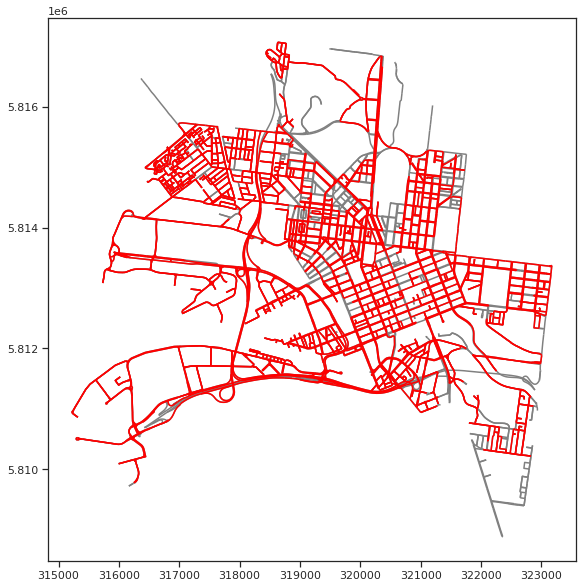

In [119]:
fig, ax = plt.subplots(figsize=(15,10))
edges_G2_lsg.plot(ax=ax,color='red',legend=True, linewidth=1.5,alpha=1,zorder=9)
G_edges.plot(ax=ax,color='grey',legend=True, linewidth=1.5,alpha=1,zorder=1)

In [120]:
#nx.all_pairs_node_connectivity(G)

In [121]:
list(G.edges(data = True))[0]

(21578145,
 683094366,
 {'osmid': [484854832, 28119418, 1083073387, 775968519],
  'oneway': True,
  'lanes': ['3', '4'],
  'ref': 'M1',
  'name': 'West Gate Freeway',
  'highway': 'motorway',
  'maxspeed': '80',
  'length': 1827.578,
  'geometry': <shapely.geometry.linestring.LineString at 0x7f3db729c9a0>,
  'delay_traveltime': 99.73955500505527,
  'traveltime': 82.39867591368365,
  'delay_timeratio': 0.21045094352653163,
  'flooddepth': 40.369830480436,
  'direction': (21578145, 683094366)})

Statistics gaint strongly connected components for original graph and disrupted graph.

In [122]:
G_ave_traveltime = nx.average_shortest_path_length(G,weight='traveltime')

In [123]:
G_ave_traveltime

240.0756721820226

In [124]:
G2_ave_delaytraveltime = nx.average_shortest_path_length(G2_larsubgraph,weight='delay_traveltime')

In [125]:
G2_ave_delaytraveltime

390.299036532818

Select top 10 subgraphs in disrupted road network. Examine area-covering disruptions.

In [126]:
G2_lencomponentsList = [len(c) for c in sorted(nx.strongly_connected_components(G2), key=len, reverse=True)]

In [127]:
len(G2_lencomponentsList)

251

In [128]:
G2_lencomponentsList[:20]

[3511, 22, 10, 7, 6, 6, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2]

In [129]:
G2_allcomponentsList = [c for c in sorted(nx.strongly_connected_components(G2), key=len, reverse=True)]

In [130]:
G2_topsubList = [G2.subgraph(c).copy() for c in G2_allcomponentsList[:1]]
G2_gdfnodeList = [ox.utils_graph.graph_to_gdfs(g, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True) for g in G2_topsubList]
G2_gdfedgeList = [ox.utils_graph.graph_to_gdfs(g, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True) for g in G2_topsubList]

In [131]:
len(G2_gdfedgeList)

1

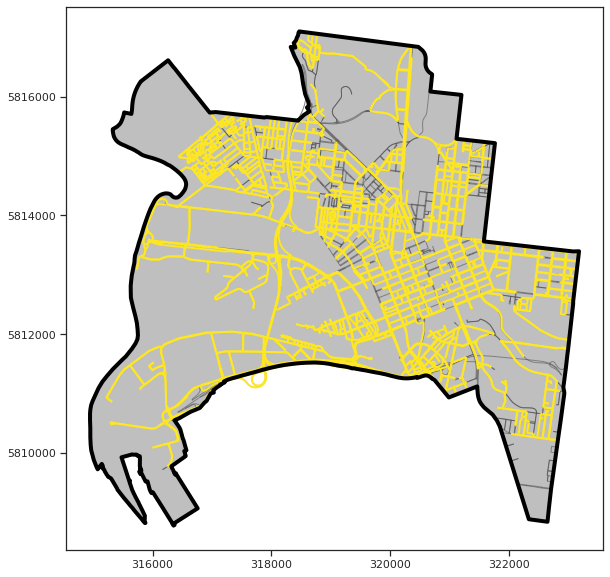

In [132]:
fig, ax = plt.subplots(figsize=(15,10))
index=0
for g in G2_gdfedgeList:
  g.plot(ax=ax,color=color2.colors[index],legend=True, linewidth=2,alpha=1,zorder=15-index)
  index=index+1
G_edges.plot(ax=ax,color='black',legend=True, linewidth=1,alpha=0.5,zorder=1)
Boundary.plot(ax=ax,facecolor='grey',alpha=0.5)
Boundary.plot(color='none',edgecolor='black',linewidth=4,alpha=1,ax=ax,zorder=25)
plt.ticklabel_format(style='plain')


### Calculation of shortest path length in G and G2

Weights applied travel time in G and delayed travel time in G2

In [133]:
G_allpairtime = dict(nx.all_pairs_dijkstra_path_length(G, weight='traveltime'))

In [134]:
len(G_allpairtime)

4102

In [135]:
G2_allpairtime = dict(nx.all_pairs_dijkstra_path_length(G2, weight='delay_traveltime'))

In [136]:
len(G2_allpairtime)

3859

## Linking the network with the Mesh Block

In [137]:
gdf_MB_centroid = gdf_MB_census.copy()
gdf_MB_centroid['geometry'] = gdf_MB_census.centroid
gdf_MB_centroid['x']=gdf_MB_centroid.centroid.x
gdf_MB_centroid['y']=gdf_MB_centroid.centroid.y

In [138]:
G_nearedge = ox.distance.nearest_edges(G, gdf_MB_centroid['x'], gdf_MB_centroid['y'])
G_nearsource = [u for u,v,key in G_nearedge]
G2_nearedge = ox.distance.nearest_edges(G2, gdf_MB_centroid['x'], gdf_MB_centroid['y'])
G2_nearsource = [u for u,v,key in G2_nearedge]

In [139]:
gdf_MB_centroid['G_nearsource'] = G_nearsource
gdf_MB_centroid['G2_nearsource'] = G2_nearsource

In [140]:
gdf_MB_near = gdf_MB_centroid[['MB_CODE_2021','G_nearsource','G2_nearsource']].copy().merge(gdf_MB_census,how='left',on='MB_CODE_2021')

In [141]:
gdf_MB_near

MB_CODE_2021  G_nearsource  G2_nearsource     MB_CAT21  \
0     20392860000      26034533       26034533   Commercial   
1     20392870000     245533066      245533066   Commercial   
2     20392890000    1492153100     1492153100   Commercial   
3     20392910000    1492150956     1492150956  Residential   
4     20392940000    2189145390     2189145390  Residential   
...           ...           ...            ...          ...   
1408  21345280000    9725730061     9725730061  Residential   
1409  21345290000      26476632       26476632   Commercial   
1410  21345300000     242400083      242400083   Commercial   
1411  21345310000     452332424      452332424  Residential   
1412  21345400000    6197570969     6197570969   Industrial   

                          SA2_NAME21  AREASQKM21  Dwelling  Person  \
0               Melbourne CBD - West      0.0111       9.0       7   
1               Melbourne CBD - East      0.0139       3.0       3   
2               Melbourne CBD - West      0.0056      33.0      34   
3               Melbourne CBD - West      0.0013     129.0     207   
4               Melbourne CBD - West      0.0024     220.0     243   
...                              ...         ...       ...     ...   
1408                Southbank - East      0.0346    1054.0     892   
1409  Southbank (West) - South Wharf      0.0468       0.0       0   
1410       Port Melbourne Industrial      0.1117       0.0       0   
1411                Southbank - East      0.0167     382.0     349   
1412       Port Melbourne Industrial      0.2580       0.0       0   

                                               geometry  ref  
0     POLYGON ((320495.537 5812757.070, 320453.835 5...  999  
1     POLYGON ((321038.421 5812969.308, 321017.917 5...  999  
2     POLYGON ((319925.555 5813033.247, 319940.943 5...  999  
3     POLYGON ((319828.097 5812871.534, 319826.072 5...  999  
4     POLYGON ((320452.584 5812491.347, 320446.870 5...  999  
...                                                 ...  ...  
1408  POLYGON ((320901.292 5811593.774, 320888.336 5...  999  
1409  POLYGON ((318833.570 5811547.956, 318840.255 5...  999  
1410  POLYGON ((317940.714 5811942.961, 317920.473 5...  999  
1411  POLYGON ((320651.057 5811540.645, 320728.691 5...  999  
1412  POLYGON ((317882.359 5811699.668, 317879.036 5...  999  

[1413 rows x 10 columns]

Get source node of the closest edge to the Mesh Block centroid. Merge it.

In [142]:
G_mesh = nodes.drop(columns=['geometry']).merge(gdf_MB_near,how='left',left_on='nodeName',right_on='G_nearsource')

G2_meshList = [
df_nodes.drop(columns=['geometry']).merge(
    gdf_MB_near,
    how='left',
    left_on='nodeName',
    right_on='G2_nearsource'
)
for df_nodes in G2_gdfnodeList
]

Extract mesh polygons from each subgraph by using left-join querying the nearest centroid.

In [143]:
diss_meshList = []
index = 0
for zone in G2_meshList:
  zone['ref'] = index
  diss_meshList.append(zone.dissolve(by='ref'))
  index=index+1

In [144]:
len(G2_meshList)

1

In [145]:
G2_meshList[0].head(2)

y              x  street_count         lon        lat  \
0  5.812807e+06  319967.726422             4  144.954709 -37.814398   
1  5.812812e+06  319980.005354             4  144.954850 -37.814358   

                                      coor   nodeName  degree highway ref_x  \
0   (319967.7264215674, 5812806.986463243)   26034526       4     NaN   NaN   
1  (319980.00535399455, 5812811.751595357)  259616706       4     NaN   NaN   

   ... G_nearsource  G2_nearsource     MB_CAT21            SA2_NAME21  \
0  ...          NaN            NaN          NaN                   NaN   
1  ...  259616706.0    259616706.0  Residential  Melbourne CBD - West   

  AREASQKM21  Dwelling  Person  \
0        NaN       NaN     NaN   
1     0.0098     860.0  1168.0   

                                            geometry  ref_y  ref  
0                                               None    NaN    0  
1  POLYGON ((320086.295 5812847.133, 320065.733 5...  999.0    0  

[2 rows x 21 columns]

In [146]:
#inter_diss_meshList = []
#for i in range(len(diss_meshList)):
#  tempo = diss_meshList.copy()
#  del tempo[i]
#  tempo = pd.concat(tempo)
#  inter_diss_meshList.append(diss_meshList[i].intersection(tempo))

In [147]:
len(G2_gdfedgeList)

1

<ipython-input-148-0c3f747e2b27>:9: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  l1 = plt.legend([fig],


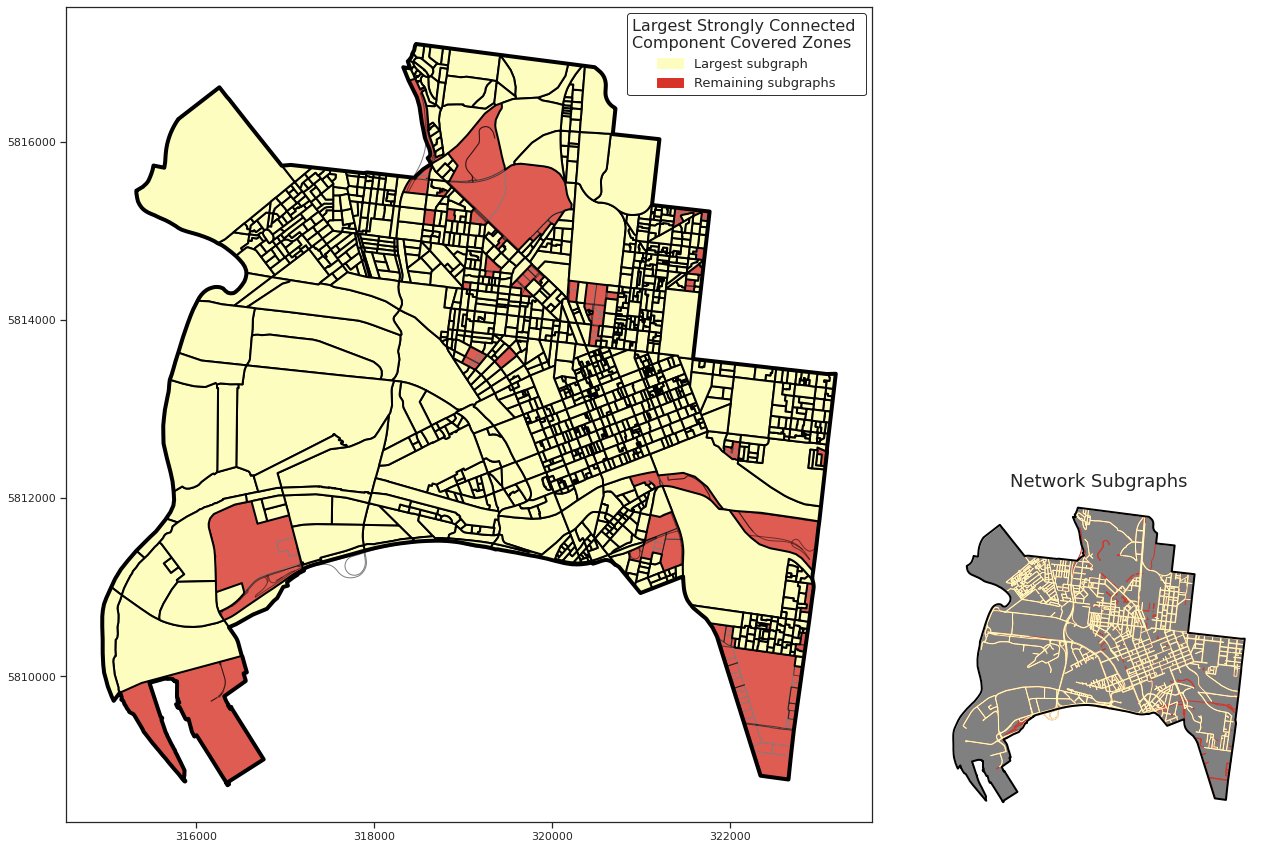

In [148]:
fig, ax = plt.subplots(figsize=(20,15))
G2_meshList[0].plot(ax=ax,color='#fcfdbf',linewidth=2,edgecolor='black',alpha=1,zorder=12)
gdf_MB_census.plot(color='#d83328',edgecolor='grey',ax=ax,alpha=0.8,zorder=1)
Boundary.plot(color='none',edgecolor='black',linewidth=4,alpha=1,ax=ax,zorder=25)

G_edges.plot(ax=ax,color='black',legend=True, linewidth=1,alpha=0.5,zorder=1)
cl = [mpatches.Patch(color='#fcfdbf',label='Largest subgraph'),mpatches.Patch(color='#d83328',label='Remaining subgraphs')]
plt.ticklabel_format(style='plain')
l1 = plt.legend([fig], 
                handles=cl,
                loc='upper right',
                title_fontsize = 16,
                fontsize = 13,
                title = 'Largest Strongly Connected \nComponent Covered Zones',
                frameon=True)
l1.get_frame().set_edgecolor('black')
l1.get_frame().set_linewidth(1)

index=1

ax2 = fig.add_axes([0.8, 0.13, 0.3, 0.3])

G2_gdfedgeList[0].plot(ax=ax2,color='#fcfdbf',legend=True, linewidth=1,alpha=1,zorder=2)
edges_2.plot(ax=ax2,color='#d83328',legend=True, linewidth=1,alpha=1,zorder=1)
#cl = [mpatches.Patch(color='#fcfdbf',label='Largest subgraph'),mpatches.Patch(color='#d83328',label='Remaining subgraphs')]

Boundary.plot(ax=ax2,facecolor='grey',alpha=1,zorder=0)
Boundary.plot(color='none',edgecolor='black',linewidth=2,alpha=1,ax=ax2,zorder=25)

ax2.axis('off')
ax2.set_title('Network Subgraphs', fontdict={'fontsize':'18', 'fontweight':'5'})


#contextily.add_basemap(ax,
#            crs=gdf_MB_census.crs, 
#            source=contextily.providers.Esri.WorldGrayCanvas,
#            attribution = False
#           )
plt.savefig('Outputs/Subgraphs.png',dpi=400,bbox_inches='tight')

Create two empty matrixes of nodes in G and the nodes in the largest SCC in G2

In [149]:
G_df_nodes = pd.DataFrame(
    index=G.nodes(),
    columns=G.nodes()
)

In [150]:
G2_df_nodes = pd.DataFrame(
    index=G2_topsubList[0].nodes(),
    columns=G2_topsubList[0].nodes()
)

From origin i to destination j.

where i is the index, j is the column.

In [151]:
gdf_MB_near.head(10)

MB_CODE_2021  G_nearsource  G2_nearsource     MB_CAT21  \
0  20392860000      26034533       26034533   Commercial   
1  20392870000     245533066      245533066   Commercial   
2  20392890000    1492153100     1492153100   Commercial   
3  20392910000    1492150956     1492150956  Residential   
4  20392940000    2189145390     2189145390  Residential   
5  20392950000    6804242153     6804242153   Commercial   
6  20392960000    8955976454     8955976454  Residential   
7  20392970000    1833110277     1833110277  Residential   
8  20393030000    1838361782     1838361782   Commercial   
9  20393080000     131124746      131124746  Residential   

             SA2_NAME21  AREASQKM21  Dwelling  Person  \
0  Melbourne CBD - West      0.0111       9.0       7   
1  Melbourne CBD - East      0.0139       3.0       3   
2  Melbourne CBD - West      0.0056      33.0      34   
3  Melbourne CBD - West      0.0013     129.0     207   
4  Melbourne CBD - West      0.0024     220.0     243   
5  Melbourne CBD - West      0.0051      78.0      48   
6  Melbourne CBD - West      0.0010     117.0      69   
7  Melbourne CBD - West      0.0029     134.0      52   
8  Melbourne CBD - East      0.0010      28.0      37   
9  Melbourne CBD - West      0.0017       6.0      16   

                                            geometry  ref  
0  POLYGON ((320495.537 5812757.070, 320453.835 5...  999  
1  POLYGON ((321038.421 5812969.308, 321017.917 5...  999  
2  POLYGON ((319925.555 5813033.247, 319940.943 5...  999  
3  POLYGON ((319828.097 5812871.534, 319826.072 5...  999  
4  POLYGON ((320452.584 5812491.347, 320446.870 5...  999  
5  POLYGON ((320537.267 5812649.270, 320579.403 5...  999  
6  POLYGON ((320256.890 5812160.226, 320249.559 5...  999  
7  POLYGON ((320429.385 5812288.030, 320448.141 5...  999  
8  POLYGON ((320966.394 5812624.178, 320968.642 5...  999  
9  POLYGON ((320361.993 5812829.330, 320375.520 5...  999

In [152]:
# Create the martix of MBs
gdf_MB_tr = pd.DataFrame(
    index=gdf_MB_near.MB_CODE_2021,
    columns=gdf_MB_near.MB_CODE_2021
)

In [153]:
gdf_MB_tr.iloc[0][0] = 1

In [154]:
G_allpairtime[60317254][2189145390]

130.16590770823143

Assign the travel time increased by query the original network and the disurpted network using the origin and destination node into the Mesh Blcok Matrix

In [155]:
for i in range(len(gdf_MB_tr)):
  G_index = gdf_MB_near['G_nearsource'][i]
  G2_index = gdf_MB_near['G2_nearsource'][i]
  for j in range(len(gdf_MB_tr)):
    G_column = gdf_MB_near['G_nearsource'][j]
    G2_column = gdf_MB_near['G2_nearsource'][j]
    try:
      tempo_G_rawtime = G_allpairtime[G_index][G_column]
      tempo_G2_delytime = G2_allpairtime[G2_index][G2_column]
      tempo_ratio = (tempo_G2_delytime-tempo_G_rawtime)/tempo_G_rawtime * 100
      if tempo_ratio < 0:
        tempo_ratio = 0
    except: 
      tempo_ratio = np.nan
    else:
      gdf_MB_tr.iloc[i][j] = tempo_ratio

In [156]:
counts_tr = gdf_MB_tr.count(axis=1)
counts_tr = counts_tr.to_list()

In [157]:
mean_tr = [np.mean(gdf_MB_tr.iloc[index]) for index in range(len(gdf_MB_tr))]
std_tr = [np.std(gdf_MB_tr.iloc[index]) for index in range(len(gdf_MB_tr))]
counts_tr = gdf_MB_tr.count(axis=1).to_list()
df_mean_tr = pd.DataFrame(
    data={
        'MB_CODE_2021':gdf_MB_tr.index,
        'mean_travelratio':mean_tr,
        'std_travelratio':std_tr,
        'counts':counts_tr
    },
    index=range(len(gdf_MB_tr))
)

In [158]:
fin_gdf_MB = gpd.GeoDataFrame(gdf_MB_near.merge(df_mean_tr, on='MB_CODE_2021',how='left'))

In [159]:
type(fin_gdf_MB)

geopandas.geodataframe.GeoDataFrame

In [160]:
#fig, ax = plt.subplots(figsize=(20,15))
#index=0
#meshList_tr_nn[index].plot(ax=ax,column='mean_travelratio',cmap='viridis',linewidth=0.5,edgecolor='black',alpha=1,legend=True,zorder=2,)
#G2_gdfedgeList[index].plot(ax=ax,color='white',legend=True, linewidth=1,alpha=1,zorder=3)
#G2_gdfedgeList[index].plot(ax=ax,color='white', linewidth=0.2,alpha=0.8,zorder=15-index)

#gdf_MB_census.plot(color='grey',edgecolor='grey',ax=ax,zorder=1)
#Boundary.plot(color='none',edgecolor='black',linewidth=4,alpha=1,ax=ax,zorder=25)

Examine the distribution

In [161]:
N, bins, patches = plt.hist(fin_gdf_MB['mean_travelratio'], 25)

cmap = plt.get_cmap('GnBu')
class1 = cmap(0.2)
class2 = cmap(0.4)
class3 = cmap(0.6)
class4 = cmap(0.8)


for i in range(0,5):
    patches[i].set_facecolor(class1)
for i in range(5,10):
    patches[i].set_facecolor(class2)
for i in range(10,15):
    patches[i].set_facecolor(class3)
for i in range(15,25):
    patches[i].set_facecolor(class4)

plt.xlabel("Average rate of travel time increase (%)", fontsize=16)  
plt.ylabel("Counts", fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

plt.show()

In [162]:
fin_gdf_MB.head(4)

MB_CODE_2021  G_nearsource  G2_nearsource     MB_CAT21  \
0  20392860000      26034533       26034533   Commercial   
1  20392870000     245533066      245533066   Commercial   
2  20392890000    1492153100     1492153100   Commercial   
3  20392910000    1492150956     1492150956  Residential   

             SA2_NAME21  AREASQKM21  Dwelling  Person  \
0  Melbourne CBD - West      0.0111       9.0       7   
1  Melbourne CBD - East      0.0139       3.0       3   
2  Melbourne CBD - West      0.0056      33.0      34   
3  Melbourne CBD - West      0.0013     129.0     207   

                                            geometry  ref  mean_travelratio  \
0  POLYGON ((320495.537 5812757.070, 320453.835 5...  999         63.527746   
1  POLYGON ((321038.421 5812969.308, 321017.917 5...  999         76.501587   
2  POLYGON ((319925.555 5813033.247, 319940.943 5...  999         53.259332   
3  POLYGON ((319828.097 5812871.534, 319826.072 5...  999         62.701364   

   std_travelratio  counts  
0        96.356910    1307  
1        43.547667    1305  
2        45.831318    1306  
3        42.982382    1302

## Visualisation of the resilience

<ipython-input-163-12de02d66007>:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  l1 = plt.legend([fig],


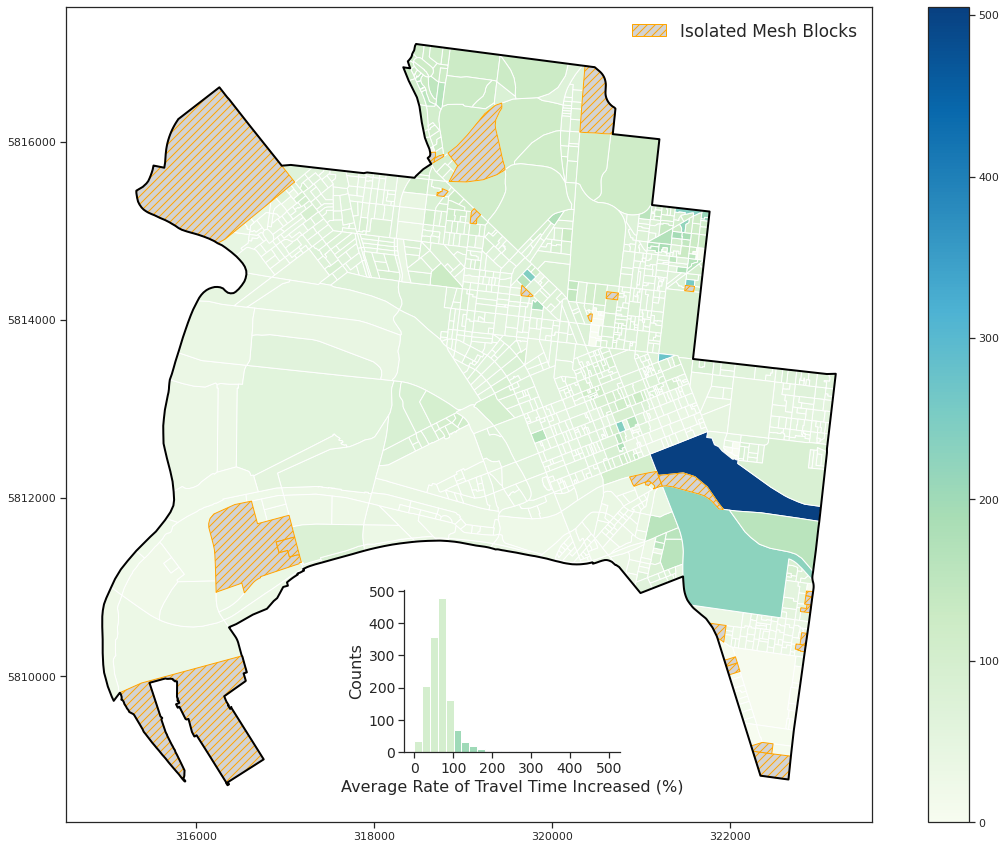

In [163]:

fig,ax = plt.subplots(figsize=(20,15))
fin_gdf_MB.plot(ax=ax,column='mean_travelratio',cmap='GnBu',edgecolor='white',legend=True,zorder=1,
        missing_kwds={
        "color": "lightgrey",
        "edgecolor": "orange",
        "hatch": "///",
        "label": "Missing values",
    })
#diss_mesh.plot(ax=ax,facecolor='none',linewidth=3,edgecolor='black',alpha=1,zorder=15-index)
Boundary.plot(ax=ax,facecolor='none',linewidth=2,edgecolor='black',zorder=2)
plt.ticklabel_format(style='plain')

cl=[mpatches.Patch(facecolor='lightgrey',edgecolor='orange',hatch='///',label='Isolated Mesh Blocks')]
l1 = plt.legend([fig], 
                handles=cl,
                loc='upper right',
                title_fontsize = 20,
                fontsize = 17,
                title='',
                frameon=False)
l1.get_frame().set_edgecolor('black')
l1.get_frame().set_linewidth(1)

ax2 = fig.add_axes([0.42, 0.19, 0.15, 0.15])
N, bins, patches = plt.hist(fin_gdf_MB['mean_travelratio'], 25)

cmap = plt.get_cmap('GnBu')
class1 = cmap(0.2)
class2 = cmap(0.4)
class3 = cmap(0.6)
class4 = cmap(0.8)


for i in range(0,5):
    patches[i].set_facecolor(class1)
for i in range(5,10):
    patches[i].set_facecolor(class2)
for i in range(10,15):
    patches[i].set_facecolor(class3)
for i in range(15,25):
    patches[i].set_facecolor(class4)




plt.xlabel("Average Rate of Travel Time Increased (%)", fontsize=16)  
plt.ylabel("Counts", fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
ax = ax2
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plt.savefig('Outputs/MeanTravelTime.png',dpi=400,bbox_inches='tight')

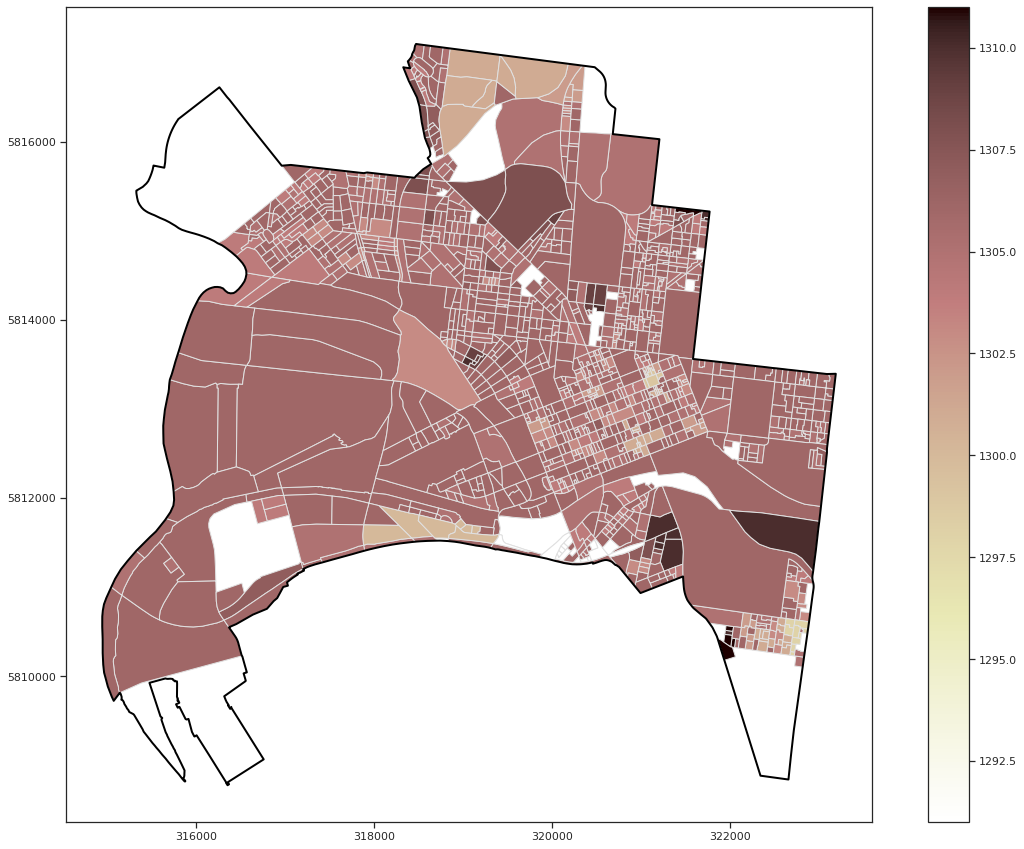

In [164]:
fig,ax = plt.subplots(figsize=(20,15))
fin_gdf_MB[fin_gdf_MB['counts']>1000].plot(ax=ax,column='counts',cmap='pink_r',edgecolor='#e0e0e0',legend=True,zorder=2)
#diss_mesh.plot(ax=ax,facecolor='none',linewidth=3,edgecolor='black',alpha=1,zorder=15-index)
Boundary.plot(ax=ax,facecolor='none',linewidth=2,edgecolor='black',zorder=2)
plt.ticklabel_format(style='plain')
plt.savefig('Outputs/DestinationCounts.png',dpi=400,bbox_inches='tight')